In [8]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
%matplotlib inline

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from PIL import Image

import cv2
import csv
import re

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Model, Sequential
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras import regularizers
from keras.regularizers import l1, l2
from keras.layers.normalization import BatchNormalization
from keras import initializers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.vgg16 import VGG16
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dense, Dropout, Activation, Flatten
from keras.backend.tensorflow_backend import set_session
import keras.backend.tensorflow_backend as KTF
import keras_applications

import sklearn 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import joblib
import time

import keras.applications.resnet50
from keras.applications.resnet50 import ResNet50


In [2]:

config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction=0.5

# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
KTF.set_session(sess)

tf.keras.backend.set_session(sess)
graph = tf.get_default_graph()

# IMPORTANT: models have to be loaded AFTER SETTING THE SESSION for keras! 
# Otherwise, their weights will be unavailable in the threads after the session there has been set
set_session(sess)

img_height = 512
img_width = 512
nb_channels = 3 #1 3

BATCH_SIZE = 4 #8 16 1
RANDOM_STATE = random_state = 42
time_str = str(time.time())

BIN_SIZE = 20#20
MAX_LIM = 200#200
MIN_LIM = 20
nb_bins = (MAX_LIM - MIN_LIM)/BIN_SIZE

IS_SCALE = False
nb_epochs = 400
print(tf.Session())

In [3]:
X_train = np.load('WaterQuality/X_train_ratio=0.2.npy')
X_test = np.load('WaterQuality/X_test_ratio=0.2.npy')
y_train = np.load('WaterQuality/y_train_ratio=0.2.npy')
y_test = np.load('WaterQuality/y_test_ratio=0.2.npy')

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=random_state)
scaler = preprocessing.MaxAbsScaler()#StandardScaler
y_train = scaler.fit_transform(y_train.reshape(-1, 1))
y_train = y_train.flatten()

joblib.dump(scaler, 'MaxAbsScaler.pkl')

# scaler_val = preprocessing.MaxAbsScaler()
y_val = scaler.transform(y_val.reshape(-1, 1))
y_val = y_val.flatten()


y_test = scaler.transform(y_test.reshape(-1, 1))
y_test = y_test.flatten()

In [4]:
X_train_g = np.zeros(X_train.shape[:-1])
X_val_g = np.zeros(X_val.shape[:-1])
X_test_g = np.zeros(X_test.shape[:-1])
for i in range(X_train.shape[0]):
    X_train_g[i] = cv2.cvtColor(X_train[i], cv2.COLOR_RGB2GRAY)
for i in range(X_val.shape[0]):
    X_val_g[i] = cv2.cvtColor(X_val[i], cv2.COLOR_RGB2GRAY)
for i in range(X_test.shape[0]):
    X_test_g[i] = cv2.cvtColor(X_test[i], cv2.COLOR_RGB2GRAY)
X_train_g = np.stack([X_train_g]*3, axis=-1)
X_val_g = np.stack([X_val_g]*3, axis=-1)
X_test_g = np.stack([X_test_g]*3, axis=-1)

In [11]:
def pretrained_models(train_shape=None, input_shape=None, model_name="resnet50", **kwargs):
    """
    model_name = "inception_v3", "mobilenet", or "densenet" "resnet50" "resnet101"
    """

    def inner( input_shape=input_shape, model_name=model_name,is_classfication=False, **kwargs):
#         nonlocal model
#         nonlocal input_shape
        if input_shape is None and train_shape is not None:
            input_shape = train_shape[1:]
        else:
            input_shape = (img_width, img_height, nb_channels)

        model = Sequential()

        if model_name == 'inception_v3':
            Kerasmodel = keras.applications.inception_v3.InceptionV3(include_top=False
                , weights='imagenet'
                # , input_tensor=inputs
                , input_shape=input_shape
                , pooling=None)
        if model_name == 'mobilenet':
            Kerasmodel = keras.applications.mobilenet.MobileNet(include_top=False
                , weights='imagenet'
                # , input_tensor=inputs
                , input_shape=input_shape
                , pooling=None)
        if model_name == 'densenet':
            Kerasmodel = keras.applications.densenet.DenseNet121(include_top=False
                , weights='imagenet'
                # , input_tensor=inputs
                , input_shape=input_shape
                , pooling=None)
        if model_name == 'resnet50':
            Kerasmodel = keras.applications.resnet50.ResNet50(include_top=False
                , weights='imagenet'
                # , input_tensor=inputs
                , input_shape=input_shape
                , pooling=None)
        if model_name == 'resnet101':
            Kerasmodel = keras.applications.resnet101.ResNet101(include_top=False
                , weights='imagenet'
                # , input_tensor=inputs
                , input_shape=input_shape
                , pooling=None)
        model.add(Flatten())
        # model.add(Dropout(0.5))
#         model.add(Dense(256, kernel_initializer='he_normal', use_bias=True, kernel_regularizer=l2(0.2)))
#         model.add(Dropout(0.5))

        if is_classfication == False:
            print('categorical false')
            model.add(Dense(1,kernel_initializer='he_normal'))
            model.add(Activation('linear')) #softmax
            model = Model( inputs=Kerasmodel.input , outputs=model(Kerasmodel.output) )
            # model = Model( inputs=inputs, outputs=result )
            model.compile(loss='mean_squared_error', #mse binary_crossentropy Dice-coefficient loss function vs cross-entropy
                optimizer=optimizers.Adam(lr=5e-3),
                metrics=['mse'])
        elif is_classfication == True:
            print('categorical true')
            model.add(Dense(int(kwargs['nb_classes']), kernel_initializer='he_normal'))
            model.add(Activation('sigmoid')) #softmax
            model = Model( inputs=Kerasmodel.input , outputs=model(Kerasmodel.output) )

            model.compile(loss='binary_crossentropy',
                optimizer=optimizers.Adam(lr=5e-3),
                metrics=['accuracy'])
        else:
            raise Exception('No model returned')
        print(model.summary())
        return model
    return inner


def run_model(train, label, vali_train, vali_label, test, test_label, model_name="resnet50",  model_fn = VGG16, is_classfication=False, fold=1, nb_classes=1):
    model = model_fn( is_classfication=is_classfication, nb_classes=nb_classes)
    early_stop = EarlyStopping(monitor='val_mean_squared_error', patience=30)
    # model.load_weights('./modelWights/regression_model'+model_fn.__name__+'.h5')
    model_checkpoint = ModelCheckpoint('./modelWights/weights_'+model_name+'_fold_'+str(fold)+time_str+'_gray_scale.h5', monitor='val_loss', save_best_only=True)

    history = model.fit(train, label, batch_size=BATCH_SIZE, epochs=nb_epochs, validation_data=(vali_train, vali_label), callbacks=[model_checkpoint])
    # print(history.history)
    import json
    with open('./modelWights/history.json', 'w') as f:
        json.dump(history.history, f)
    y_pred = model.predict(test, batch_size=1, verbose=1)

    y_test = test_label
    
    return y_pred, y_test

def post_training_data(y_test, y_pred, is_scaler=True ):
    if not is_scaler:
        y_test = y_test
        y_pred = y_pred
    else:
        scaler_val = joblib.load('MaxAbsScaler.pkl')
        y_test, y_pred = transform_y(y_test, y_pred, scaler_val)

    np.save('y_pred.npy', y_pred)
    np.save('y_test_transformed.npy', y_test)
    print(y_pred.shape)###
    print(y_test.shape)###
    y_pred = y_pred.flatten()
    print(y_pred)###
    print(y_test)###
    # y_test = y_test.flatten()

    # if is_categorical:
    #     y_pred = y_pred.reshape(-1,2)
    #     y_test = y_test[:,0]
    #     y_pred = y_pred[:,0]

    ########### margin cut off ###########
    y_pred[np.where(y_pred>500)  ] = 500
    y_pred[np.where(y_pred<0) ] = 0
    return y_pred, y_test

def transform_y(y_test, y_pred, scaler_test):
    y_test = y_test.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    y_test = scaler_test.inverse_transform(y_test)
    y_pred = scaler_test.inverse_transform(y_pred)
    y_test = y_test.flatten()
    y_pred = y_pred.flatten()
    return y_test, y_pred

def save_result(name,y_pred,y_true):
    with open(name,"a") as csvfile:
        writer = csv.writer(csvfile)
        y_diff = [(y_pred[i] - y_true[i]) for i in range(len(y_pred))]
        y = [y_pred, y_true, y_diff]
        mse = 0.0
        for num in range(len(y_diff)):
            mse += pow(y_diff[num],2) / len(y_diff)
        print('mse = ', mse)
        writer.writerows(y)
        
def reinitLayers(model):
    session = K.get_session()
    for layer in model.layers: 
        if isinstance(layer, keras.engine.network.Network):
            reinitLayers(layer)
            continue
        print("LAYER::", layer.name)
        for v in layer.__dict__:
            v_arg = getattr(layer,v)
            if hasattr(v_arg,'initializer'):
                initializer_method = getattr(v_arg, 'initializer')
                initializer_method.run(session=session)
                print('reinitializing layer {}.{}'.format(layer.name, v))

In [12]:
model_fn = pretrained_models(model_name="resnet50") #dnn_model VGG

In [14]:

y_pred, y_test_ = run_model(X_train_g, y_train, X_val_g, y_val, X_test_g, y_test, model_name="resnet50", model_fn = model_fn,is_classfication=False, nb_classes=1)


categorical false
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

Train on 1053 samples, validate on 264 samples
Epoch 1/400
1053/1053 [==============================] - 115s 109ms/step - loss: 803.4075 - mean_squared_error: 803.4075 - val_loss: 92.9796 - val_mean_squared_error: 92.9796
Epoch 2/400
1053/1053 [==============================] - 88s 84ms/step - loss: 25.6277 - mean_squared_error: 25.6277 - val_loss: 41.8336 - val_mean_squared_error: 41.8336
Epoch 3/400
1053/1053 [==============================] - 89s 85ms/step - loss: 4.2023 - mean_squared_error: 4.2023 - val_loss: 8.8229 - val_mean_squared_error: 8.8229
Epoch 4/400
1053/1053 [==============================] - 83s 78ms/step - loss: 0.9280 - mean_squared_error: 0.9280 - val_loss: 10.2148 - val_mean_squared_error: 10.2148
Epoch 5/400
1053/1053 [==============================] - 82s 78ms/step - loss: 1.5310 - mean_squared_error: 1.5310 - val_loss: 11.9949 - val_mean_squared_error: 11.9949
Epoch 6/400
1053/1053 [==============================] - 81s 77ms/step - loss: 9.8627 - mean_squared_e

1053/1053 [==============================] - 91s 86ms/step - loss: 0.1532 - mean_squared_error: 0.1532 - val_loss: 724.7141 - val_mean_squared_error: 724.7141
Epoch 98/400
1053/1053 [==============================] - 91s 86ms/step - loss: 31.2330 - mean_squared_error: 31.2330 - val_loss: 9.1080 - val_mean_squared_error: 9.1080
Epoch 99/400
1053/1053 [==============================] - 91s 87ms/step - loss: 0.0872 - mean_squared_error: 0.0872 - val_loss: 0.0747 - val_mean_squared_error: 0.0747
Epoch 100/400
1053/1053 [==============================] - 90s 86ms/step - loss: 0.0469 - mean_squared_error: 0.0469 - val_loss: 0.0464 - val_mean_squared_error: 0.0464
Epoch 101/400
1053/1053 [==============================] - 91s 86ms/step - loss: 0.0384 - mean_squared_error: 0.0384 - val_loss: 0.0280 - val_mean_squared_error: 0.0280
Epoch 102/400
1053/1053 [==============================] - 94s 89ms/step - loss: 0.0254 - mean_squared_error: 0.0254 - val_loss: 0.0212 - val_mean_squared_error: 0.0

Epoch 193/400
1053/1053 [==============================] - 117s 111ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 194/400
1053/1053 [==============================] - 130s 123ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 195/400
1053/1053 [==============================] - 126s 119ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 196/400
1053/1053 [==============================] - 120s 114ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 197/400
1053/1053 [==============================] - 142s 134ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 198/400
1053/1053 [==============================] - 151s 143ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0044 - val_m

1053/1053 [==============================] - 128s 121ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.0462 - val_mean_squared_error: 0.0462
Epoch 290/400
1053/1053 [==============================] - 123s 117ms/step - loss: 0.0440 - mean_squared_error: 0.0440 - val_loss: 0.0464 - val_mean_squared_error: 0.0464
Epoch 291/400
1053/1053 [==============================] - 115s 109ms/step - loss: 0.0441 - mean_squared_error: 0.0441 - val_loss: 0.0466 - val_mean_squared_error: 0.0466
Epoch 292/400
1053/1053 [==============================] - 130s 124ms/step - loss: 0.0442 - mean_squared_error: 0.0442 - val_loss: 0.0463 - val_mean_squared_error: 0.0463
Epoch 293/400
1053/1053 [==============================] - 118s 112ms/step - loss: 0.0440 - mean_squared_error: 0.0440 - val_loss: 0.0468 - val_mean_squared_error: 0.0468
Epoch 294/400
1053/1053 [==============================] - 132s 125ms/step - loss: 0.0440 - mean_squared_error: 0.0440 - val_loss: 0.0463 - val_mean_squared_er

1053/1053 [==============================] - 90s 85ms/step - loss: 0.0442 - mean_squared_error: 0.0442 - val_loss: 0.0463 - val_mean_squared_error: 0.0463
Epoch 386/400
1053/1053 [==============================] - 92s 87ms/step - loss: 0.0440 - mean_squared_error: 0.0440 - val_loss: 0.0461 - val_mean_squared_error: 0.0461
Epoch 387/400
1053/1053 [==============================] - 90s 86ms/step - loss: 0.0439 - mean_squared_error: 0.0439 - val_loss: 0.0465 - val_mean_squared_error: 0.0465
Epoch 388/400
1053/1053 [==============================] - 91s 86ms/step - loss: 0.0440 - mean_squared_error: 0.0440 - val_loss: 0.0462 - val_mean_squared_error: 0.0462
Epoch 389/400
1053/1053 [==============================] - 92s 88ms/step - loss: 0.0440 - mean_squared_error: 0.0440 - val_loss: 0.0463 - val_mean_squared_error: 0.0463
Epoch 390/400
1053/1053 [==============================] - 91s 87ms/step - loss: 0.0440 - mean_squared_error: 0.0440 - val_loss: 0.0461 - val_mean_squared_error: 0.0461


NameError: name 'is_scaler' is not defined

In [19]:
from keras.models import load_model
model = load_model('./modelWights/weights_resnet50_fold_11570509297.3577418_gray_scale.h5')
y_pred = model.predict(X_test, batch_size=1, verbose=1)
y_test_ = y_test
time_str = str(time.time())
y_pred, y_test_ = post_training_data(y_test_, y_pred)
predicted_file = 'regress_'+model_fn.__name__+"resnet50"+time_str+'_gray_scale.csv'
save_result("./result/"+predicted_file,y_pred,y_test_)
# draw_scatter(predicted_file, "resnet101")

330/330 [==============================] - 38s 114ms/step
(330,)
(330,)
[ 56.97173    39.09628   254.6135    265.0663    524.9647    158.76357
 249.61913    65.75686   160.45789   147.94812   222.82823    14.15632
 146.38806    55.69239   140.03856    23.388922  112.68035   142.1023
 243.96101   155.98552   487.3062    259.1172    275.48492    61.5182
  62.932186   58.56553   150.4173     60.131027  121.69925   117.84922
 121.12922    92.63883    88.32725    44.95533   133.37387   150.64424
 297.5664     30.693964   24.726406  361.60596   256.6332    286.14972
 136.44533   231.74408   270.04456   276.81927    44.445755    3.8105621
  62.72774   161.20285    35.903336   84.789665  127.295555   20.923145
 160.0852    115.94755    81.006294  233.1496    202.4234    -14.231533
 229.66307   289.95526    36.227837  436.9232    240.67078   266.18576
 259.27576   226.55405   262.921      70.26511   240.27756   -15.753969
 175.17888   119.50866    40.634632  189.17473   147.04182   107.22235
 1

In [31]:
y_pred = model.predict(X_test_g, batch_size=1, verbose=1)
y_test_ = y_test
time_str = str(time.time())
y_pred, y_test_ = post_training_data(y_test_, y_pred)
predicted_file = 'regress_'+model_fn.__name__+"resnet50"+time_str+'_gray_scale_pred_color.csv'
save_result("./result/"+predicted_file,y_pred,y_test_)
# draw_scatter(predicted_file, "resnet101")

330/330 [==============================] - 26s 78ms/step
(330,)
(330,)
[ 56.97173    39.09628   254.6135    265.0663    524.9647    158.76357
 249.61913    65.75686   160.45789   147.94812   222.82823    14.15632
 146.38806    55.69239   140.03856    23.388922  112.68035   142.1023
 243.96101   155.98552   487.3062    259.1172    275.48492    61.5182
  62.932186   58.56553   150.4173     60.131027  121.69925   117.84922
 121.12922    92.63883    88.32725    44.95533   133.37387   150.64424
 297.5664     30.693964   24.726406  361.60596   256.6332    286.14972
 136.44533   231.74408   270.04456   276.81927    44.445755    3.8105621
  62.72774   161.20285    35.903336   84.789665  127.295555   20.923145
 160.0852    115.94755    81.006294  233.1496    202.4234    -14.231533
 229.66307   289.95526    36.227837  436.9232    240.67078   266.18576
 259.27576   226.55405   262.921      70.26511   240.27756   -15.753969
 175.17888   119.50866    40.634632  189.17473   147.04182   107.22235
 11

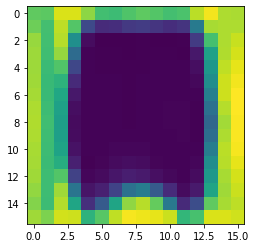

In [20]:
from keras import backend as K

get_layer_output = K.function([model.layers[0].input, K.learning_phase()],[model.layers[-3].output])
layer_output = get_layer_output([X_train[2].reshape(1,512,512,3), 0])[0]
plt.imshow(layer_output[0,:,:,0])

[[-369.41626 -526.9378  -430.79715 ... -362.27216 -358.80005 -254.3877 ]
 [-519.6171  -739.9861  -589.9607  ... -488.06784 -481.176   -342.8683 ]
 [-482.4566  -677.2405  -518.43726 ... -421.33786 -411.26694 -290.80206]
 ...
 [-469.83298 -654.7402  -492.50415 ... -401.03516 -389.57565 -274.44693]
 [-465.01306 -644.79114 -479.0014  ... -389.45715 -381.78152 -269.61908]
 [-310.00427 -432.5793  -319.30478 ... -258.98465 -255.72847 -181.82275]]


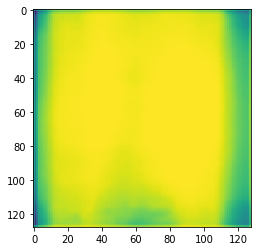

In [33]:
get_3rd_layer_output = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[10].output])
# output in test mode = 0
layer_output = get_3rd_layer_output([X_train[2].reshape(1,512,512,3), 0])[0]
imshow(layer_output[0,:,:,0])
print(layer_output[0,:,:,0])

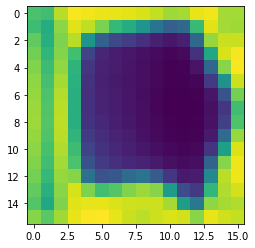

In [22]:
get_layer_output = K.function([model.layers[0].input, K.learning_phase()],[model.layers[-3].output])
layer_output = get_layer_output([X_train[0].reshape(1,512,512,3), 0])[0]
plt.imshow(layer_output[0,:,:,0])

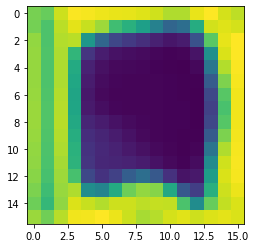

In [23]:
get_layer_output = K.function([model.layers[0].input, K.learning_phase()],[model.layers[-3].output])
layer_output = get_layer_output([X_test[0].reshape(1,512,512,3), 0])[0]
plt.imshow(layer_output[0,:,:,0])

In [38]:
get_layer_output = K.function([model.layers[0].input],[model.layers[-3].output])
layer_output = get_layer_output([X_test_g[1].reshape(1,512,512,3), 0])[1]
plt.imshow(layer_output[0,:,:,0])
print(layer_output[0,:,:,0])


IndexError: list index out of range

In [6]:
pic = X_train[1]
model = Sequential()
#model.add(Input(shape=pic.shape))
# model.add(Conv2D(filters=4, kernel_size=(7,7), strides=1, input_shape=pic.shape))
Kerasmodel = keras.applications.resnet50.ResNet50(include_top=True
                , weights=None#'imagenet'
                # , input_tensor=inputs
                , input_shape=pic.shape
                )
# Kerasmodel._layers.pop()
# Kerasmodel.layers.pop()
# model.add(Flatten())
model.add(Dense(1,kernel_initializer='he_normal'))
model.add(Activation('linear')) #softmax
model = Model( inputs=Kerasmodel.input , outputs=model(Kerasmodel.layers[-2].output))
model.compile(loss='mean_squared_error', #mse binary_crossentropy Dice-coefficient loss function vs cross-entropy
                optimizer=optimizers.Adam(lr=5e-3),
                metrics=['mse'])

model.summary()     



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

## resnet 50 color without pretrain

In [8]:
time_str = str(time.time())
print(time_str)
reinitLayers(model)
early_stop = EarlyStopping(monitor='val_mean_squared_error', patience=30)
# model.load_weights('./modelWights/regression_model'+model_fn.__name__+'.h5')
model_checkpoint = ModelCheckpoint('./modelWights/weights_'+'resnet50_without_pre'+time_str+'_color.h5', monitor='val_loss', save_best_only=True)
tensorboard = keras.callbacks.tensorboard_v1.TensorBoard(log_dir="~/data/projects_logs/water_logs/resnet50_without_pre_color_{}".format(time_str), histogram_freq=2,write_grads=True)
history = model.fit(X_train, y_train, batch_size=4, epochs=200, validation_data=(X_val, y_val), callbacks=[model_checkpoint])
# print(history.history)

y_pred_ = model.predict(X_test, batch_size=1, verbose=1)
y_pred_, y_test_ = post_training_data(y_test, y_pred_)
predicted_file = 'regress_'+"resnet50_without_pre"+"resnet50"+time_str+'_color.csv'
save_result("./result/"+predicted_file,y_pred_,y_test_)

1570924433.358989
LAYER:: input_1
LAYER:: conv1_pad
LAYER:: conv1
reinitializing layer conv1.kernel
reinitializing layer conv1.bias
LAYER:: bn_conv1
reinitializing layer bn_conv1.gamma
reinitializing layer bn_conv1.beta
reinitializing layer bn_conv1.moving_mean
reinitializing layer bn_conv1.moving_variance
LAYER:: activation_1
LAYER:: pool1_pad
LAYER:: max_pooling2d_1
LAYER:: res2a_branch2a
reinitializing layer res2a_branch2a.kernel
reinitializing layer res2a_branch2a.bias
LAYER:: bn2a_branch2a
reinitializing layer bn2a_branch2a.gamma
reinitializing layer bn2a_branch2a.beta
reinitializing layer bn2a_branch2a.moving_mean
reinitializing layer bn2a_branch2a.moving_variance
LAYER:: activation_2
LAYER:: res2a_branch2b
reinitializing layer res2a_branch2b.kernel
reinitializing layer res2a_branch2b.bias
LAYER:: bn2a_branch2b
reinitializing layer bn2a_branch2b.gamma
reinitializing layer bn2a_branch2b.beta
reinitializing layer bn2a_branch2b.moving_mean
reinitializing layer bn2a_branch2b.moving_v

1053/1053 [==============================] - 104s 99ms/step - loss: 0.6636 - mse: 0.6636 - val_loss: 0.7552 - val_mse: 0.7552
Epoch 2/200
1053/1053 [==============================] - 103s 98ms/step - loss: 0.0360 - mse: 0.0360 - val_loss: 2.6218 - val_mse: 2.6218
Epoch 3/200
1053/1053 [==============================] - 103s 98ms/step - loss: 0.0372 - mse: 0.0372 - val_loss: 0.0844 - val_mse: 0.0844
Epoch 4/200
1053/1053 [==============================] - 103s 98ms/step - loss: 0.0215 - mse: 0.0215 - val_loss: 0.7891 - val_mse: 0.7891
Epoch 5/200
1053/1053 [==============================] - 103s 98ms/step - loss: 0.0250 - mse: 0.0250 - val_loss: 0.0375 - val_mse: 0.0375
Epoch 6/200
1053/1053 [==============================] - 103s 98ms/step - loss: 0.0211 - mse: 0.0211 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 7/200
1053/1053 [==============================] - 103s 98ms/step - loss: 0.0190 - mse: 0.0190 - val_loss: 0.7257 - val_mse: 0.7257
Epoch 8/200
1053/1053 [=======================

1053/1053 [==============================] - 103s 98ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 61/200
1053/1053 [==============================] - 103s 98ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0203 - val_mse: 0.0203
Epoch 62/200
1053/1053 [==============================] - 103s 98ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 63/200
1053/1053 [==============================] - 103s 98ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0149 - val_mse: 0.0149
Epoch 64/200
1053/1053 [==============================] - 103s 98ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 65/200
1053/1053 [==============================] - 103s 98ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 66/200
1053/1053 [==============================] - 103s 98ms/step - loss: 0.0030 - mse: 0.0030 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 67/200
1053/1053 [================

Epoch 119/200
1053/1053 [==============================] - 103s 98ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 120/200
1053/1053 [==============================] - 103s 98ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 121/200
1053/1053 [==============================] - 103s 98ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 122/200
1053/1053 [==============================] - 103s 98ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 123/200
1053/1053 [==============================] - 103s 98ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 124/200
1053/1053 [==============================] - 103s 98ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 125/200
1053/1053 [==============================] - 103s 98ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 126/200
1053/1

In [7]:

pic = X_train[1]
model = Sequential()
#model.add(Input(shape=pic.shape))
# model.add(Conv2D(filters=4, kernel_size=(7,7), strides=1, input_shape=pic.shape))
Kerasmodel = keras.applications.resnet50.ResNet50(include_top=True
                , weights=None#'imagenet'
                # , input_tensor=inputs
                , input_shape=pic.shape
                )
# Kerasmodel._layers.pop()
# Kerasmodel.layers.pop()
# model.add(Flatten())
model.add(Dense(1,kernel_initializer='he_normal'))
model.add(Activation('linear')) #softmax
model = Model( inputs=Kerasmodel.input , outputs=model(Kerasmodel.layers[-2].output))
model.compile(loss='mean_squared_error', #mse binary_crossentropy Dice-coefficient loss function vs cross-entropy
                optimizer=optimizers.Adam(lr=5e-3),
                metrics=['mse'])

model.summary()  
time_str = str(time.time())
print(time_str)
reinitLayers(model)
early_stop = EarlyStopping(monitor='val_mean_squared_error', patience=30)
# model.load_weights('./modelWights/regression_model'+model_fn.__name__+'.h5')
model_checkpoint = ModelCheckpoint('./modelWights/weights_'+'resnet50_without_pre'+time_str+'_color.h5', monitor='val_loss', save_best_only=True)
tensorboard = keras.callbacks.tensorboard_v1.TensorBoard(log_dir="~/data/projects_logs/water_logs/resnet50_without_pre_color_{}".format(time_str), histogram_freq=2,write_grads=True)
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=100, validation_data=(X_val, y_val), callbacks=[model_checkpoint, ])
# print(history.history)
y_pred_ = model.predict(X_test, batch_size=1, verbose=1)
y_pred_, y_test_ = post_training_data(y_test, y_pred_)
predicted_file = 'regress_'+"resnet50_without_pre"+"resnet50"+time_str+'_color.csv'
save_result("./result/"+predicted_file,y_pred_,y_test_)


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

LAYER:: input_2
LAYER:: conv1_pad
LAYER:: conv1
reinitializing layer conv1.kernel
reinitializing layer conv1.bias
LAYER:: bn_conv1
reinitializing layer bn_conv1.gamma
reinitializing layer bn_conv1.beta
reinitializing layer bn_conv1.moving_mean
reinitializing layer bn_conv1.moving_variance
LAYER:: activation_51
LAYER:: pool1_pad
LAYER:: max_pooling2d_2
LAYER:: res2a_branch2a
reinitializing layer res2a_branch2a.kernel
reinitializing layer res2a_branch2a.bias
LAYER:: bn2a_branch2a
reinitializing layer bn2a_branch2a.gamma
reinitializing layer bn2a_branch2a.beta
reinitializing layer bn2a_branch2a.moving_mean
reinitializing layer bn2a_branch2a.moving_variance
LAYER:: activation_52
LAYER:: res2a_branch2b
reinitializing layer res2a_branch2b.kernel
reinitializing layer res2a_branch2b.bias
LAYER:: bn2a_branch2b
reinitializing layer bn2a_branch2b.gamma
reinitializing layer bn2a_branch2b.beta
reinitializing layer bn2a_branch2b.moving_mean
reinitializing layer bn2a_branch2b.moving_variance
LAYER:: 

reinitializing layer bn4a_branch2a.moving_mean
reinitializing layer bn4a_branch2a.moving_variance
LAYER:: activation_73
LAYER:: res4a_branch2b
reinitializing layer res4a_branch2b.kernel
reinitializing layer res4a_branch2b.bias
LAYER:: bn4a_branch2b
reinitializing layer bn4a_branch2b.gamma
reinitializing layer bn4a_branch2b.beta
reinitializing layer bn4a_branch2b.moving_mean
reinitializing layer bn4a_branch2b.moving_variance
LAYER:: activation_74
LAYER:: res4a_branch2c
reinitializing layer res4a_branch2c.kernel
reinitializing layer res4a_branch2c.bias
LAYER:: res4a_branch1
reinitializing layer res4a_branch1.kernel
reinitializing layer res4a_branch1.bias
LAYER:: bn4a_branch2c
reinitializing layer bn4a_branch2c.gamma
reinitializing layer bn4a_branch2c.beta
reinitializing layer bn4a_branch2c.moving_mean
reinitializing layer bn4a_branch2c.moving_variance
LAYER:: bn4a_branch1
reinitializing layer bn4a_branch1.gamma
reinitializing layer bn4a_branch1.beta
reinitializing layer bn4a_branch1.movi

reinitializing layer bn5b_branch2c.gamma
reinitializing layer bn5b_branch2c.beta
reinitializing layer bn5b_branch2c.moving_mean
reinitializing layer bn5b_branch2c.moving_variance
LAYER:: add_31
LAYER:: activation_96
LAYER:: res5c_branch2a
reinitializing layer res5c_branch2a.kernel
reinitializing layer res5c_branch2a.bias
LAYER:: bn5c_branch2a
reinitializing layer bn5c_branch2a.gamma
reinitializing layer bn5c_branch2a.beta
reinitializing layer bn5c_branch2a.moving_mean
reinitializing layer bn5c_branch2a.moving_variance
LAYER:: activation_97
LAYER:: res5c_branch2b
reinitializing layer res5c_branch2b.kernel
reinitializing layer res5c_branch2b.bias
LAYER:: bn5c_branch2b
reinitializing layer bn5c_branch2b.gamma
reinitializing layer bn5c_branch2b.beta
reinitializing layer bn5c_branch2b.moving_mean
reinitializing layer bn5c_branch2b.moving_variance
LAYER:: activation_98
LAYER:: res5c_branch2c
reinitializing layer res5c_branch2c.kernel
reinitializing layer res5c_branch2c.bias
LAYER:: bn5c_bran

Epoch 50/100
1053/1053 [==============================] - 100s 95ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 51/100
1053/1053 [==============================] - 100s 95ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 52/100
1053/1053 [==============================] - 100s 95ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0031 - val_mse: 0.0031
Epoch 53/100
1053/1053 [==============================] - 100s 95ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 54/100
1053/1053 [==============================] - 100s 95ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 55/100
1053/1053 [==============================] - 100s 95ms/step - loss: 0.0176 - mse: 0.0176 - val_loss: 0.0538 - val_mse: 0.0538
Epoch 56/100
1053/1053 [==============================] - 100s 95ms/step - loss: 0.0084 - mse: 0.0084 - val_loss: 0.0282 - val_mse: 0.0282
Epoch 57/100
1053/1053 [===

In [8]:
  
time_str = str(time.time())
print(time_str)
reinitLayers(model)
early_stop = EarlyStopping(monitor='val_mean_squared_error', patience=30)
# model.load_weights('./modelWights/regression_model'+model_fn.__name__+'.h5')
model_checkpoint = ModelCheckpoint('./modelWights/weights_'+'resnet50_without_pre'+time_str+'_color.h5', monitor='val_loss', save_best_only=True)
tensorboard = keras.callbacks.tensorboard_v1.TensorBoard(log_dir="~/data/projects_logs/water_logs/resnet50_without_pre_color_{}".format(time_str), histogram_freq=2,write_grads=True)

history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=100, validation_data=(X_val, y_val), callbacks=[model_checkpoint, ])
# print(history.history)
y_pred_ = model.predict(X_test, batch_size=1, verbose=1)
y_pred_, y_test_ = post_training_data(y_test, y_pred_)
predicted_file = 'regress_'+"resnet50_without_pre"+"resnet50"+time_str+'_color.csv'
save_result("./result/"+predicted_file,y_pred_,y_test_)


1570958763.4950016
LAYER:: input_2
LAYER:: conv1_pad
LAYER:: conv1
reinitializing layer conv1.kernel
reinitializing layer conv1.bias
LAYER:: bn_conv1
reinitializing layer bn_conv1.gamma
reinitializing layer bn_conv1.beta
reinitializing layer bn_conv1.moving_mean
reinitializing layer bn_conv1.moving_variance
LAYER:: activation_51
LAYER:: pool1_pad
LAYER:: max_pooling2d_2
LAYER:: res2a_branch2a
reinitializing layer res2a_branch2a.kernel
reinitializing layer res2a_branch2a.bias
LAYER:: bn2a_branch2a
reinitializing layer bn2a_branch2a.gamma
reinitializing layer bn2a_branch2a.beta
reinitializing layer bn2a_branch2a.moving_mean
reinitializing layer bn2a_branch2a.moving_variance
LAYER:: activation_52
LAYER:: res2a_branch2b
reinitializing layer res2a_branch2b.kernel
reinitializing layer res2a_branch2b.bias
LAYER:: bn2a_branch2b
reinitializing layer bn2a_branch2b.gamma
reinitializing layer bn2a_branch2b.beta
reinitializing layer bn2a_branch2b.moving_mean
reinitializing layer bn2a_branch2b.movin

reinitializing layer res5a_branch1.kernel
reinitializing layer res5a_branch1.bias
LAYER:: bn5a_branch2c
reinitializing layer bn5a_branch2c.gamma
reinitializing layer bn5a_branch2c.beta
reinitializing layer bn5a_branch2c.moving_mean
reinitializing layer bn5a_branch2c.moving_variance
LAYER:: bn5a_branch1
reinitializing layer bn5a_branch1.gamma
reinitializing layer bn5a_branch1.beta
reinitializing layer bn5a_branch1.moving_mean
reinitializing layer bn5a_branch1.moving_variance
LAYER:: add_30
LAYER:: activation_93
LAYER:: res5b_branch2a
reinitializing layer res5b_branch2a.kernel
reinitializing layer res5b_branch2a.bias
LAYER:: bn5b_branch2a
reinitializing layer bn5b_branch2a.gamma
reinitializing layer bn5b_branch2a.beta
reinitializing layer bn5b_branch2a.moving_mean
reinitializing layer bn5b_branch2a.moving_variance
LAYER:: activation_94
LAYER:: res5b_branch2b
reinitializing layer res5b_branch2b.kernel
reinitializing layer res5b_branch2b.bias
LAYER:: bn5b_branch2b
reinitializing layer bn5b

1053/1053 [==============================] - 48s 46ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 100/100
330/330 [==============================] - 6s 18ms/step
(330,)
(330,)
[ -7.544741   47.626415  236.28307   209.78804   420.91638   117.17326
 222.61697    18.179714  141.29085   128.65845   250.33588    10.225937
 145.00607   174.92581    88.36127    10.171339  120.657684  106.71148
 248.38469   197.00632   418.27786   244.2723    251.34259    71.2164
  39.180725   78.391335  106.03248   -47.693863  123.54485   116.79374
 140.03738    71.069176  101.034874   36.90246   119.82554   162.93727
 262.19946     1.9213855  23.854048  365.85297   262.20544   244.87167
 138.31134   225.40646   257.0662    290.03662    15.760049   -7.8072696
  81.86143   133.60622   -21.93369    88.34348   121.369316    4.7524424
 168.24792   180.93779    95.21875   233.06107   217.97433   -37.948265
 189.36035   282.90726    19.304827  390.0171    215.77122   250.07063
 227.

[[-1.602876 -1.714657 -1.725154 -1.905815 ... -1.99617  -1.835018 -1.672766 -1.55472 ]
 [-1.626547 -1.703639 -1.874007 -2.015578 ... -2.038206 -1.992903 -1.842401 -1.556368]
 [-2.45059  -2.495802 -2.756412 -2.987875 ... -3.205384 -2.886243 -2.12324  -2.002175]
 [-2.581464 -2.636156 -3.228589 -3.844085 ... -4.178961 -3.674651 -2.766613 -2.335279]
 ...
 [-2.635763 -2.492539 -3.298693 -4.123997 ... -4.648807 -3.982989 -3.119166 -2.588822]
 [-2.355711 -2.239166 -3.107065 -3.694455 ... -4.223949 -3.626656 -2.724855 -2.437797]
 [-1.976302 -1.940042 -2.678933 -2.927193 ... -3.009618 -2.561657 -2.244801 -1.837124]
 [-1.748684 -1.95183  -2.336588 -2.763162 ... -3.112839 -2.657984 -2.096123 -1.754172]]


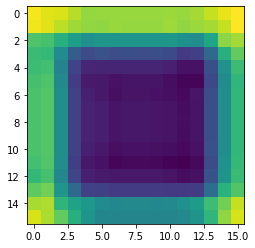

In [67]:
get_3rd_layer_output = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[-3].output])
# output in test mode = 0
layer_output = get_3rd_layer_output([X_train[2].reshape(1,512,512,3), 0])[0]
imshow(layer_output[0,:,:,0])
print(layer_output[0,:,:,0])

- pretrained with imagenet weight tend to have negative activation??
- network architacture: ResNet50 have larger absolute activation (e.g. 326) while mobileNet have lower value (e.g. 1e-20)

## resnet 50 color without pretrain--results

In [13]:
from keras.models import load_model
model = load_model('./modelWights/weights_resnet50_without_pre1570593544.982001.h5')
y_pred_ = model.predict(X_test, batch_size=1, verbose=1)

time_str = str(time.time())
y_pred_, y_test_ = post_training_data(y_test, y_pred_)
predicted_file = 'regress_'+"resnet50_without_pre"+"resnet50"+time_str+'_pred_color.csv'
save_result("./result/"+predicted_file,y_pred_,y_test_)

330/330 [==============================] - 60s 182ms/step
(330,)
(330,)
[  28.603256    71.07702    274.13205    235.63416    444.87213
  121.185776   223.74332     55.099144   151.6922     162.6203
  237.1217      49.00352    151.48047     20.321041   109.658264
   49.619377   154.97488    134.90668    248.74939    198.93352
  505.0509     239.85258    284.63034     74.45407     69.19576
   69.405495   130.32161     26.75192    136.03673    149.9048
  154.9479     125.91618    111.04576     38.923145   115.37618
  149.87564    286.33975     31.314335    74.96099    428.89722
  250.07385    278.27795    172.63026    247.9583     284.84143
  314.19244     39.688393    22.28883    101.418594   140.69962
    8.597553    94.09465    152.2221      25.92963    191.65405
  173.46999    108.332115   246.38612    229.86555      2.8510242
  231.05772    316.58746     43.660717   451.05524    223.35466
  270.56265    225.81323    215.14874    263.69553    104.63653
  235.94928     54.252686   190

## resnet 50 gray scale without pretrain

In [9]:
pic = X_train[1]
model = Sequential()
#model.add(Input(shape=pic.shape))
# model.add(Conv2D(filters=4, kernel_size=(7,7), strides=1, input_shape=pic.shape))
Kerasmodel = keras.applications.resnet50.ResNet50(include_top=True
                , weights=None#'imagenet'
                # , input_tensor=inputs
                , input_shape=pic.shape
                )
# Kerasmodel._layers.pop()
# Kerasmodel.layers.pop()
# model.add(Flatten())
model.add(Dense(1,kernel_initializer='he_normal'))
model.add(Activation('linear')) #softmax
model = Model( inputs=Kerasmodel.input , outputs=model(Kerasmodel.layers[-2].output))
model.compile(loss='mean_squared_error', #mse binary_crossentropy Dice-coefficient loss function vs cross-entropy
                optimizer=optimizers.Adam(lr=5e-3),
                metrics=['mse'])

model.summary()  
time_str = str(time.time())
print(time_str)
reinitLayers(model)
early_stop = EarlyStopping(monitor='val_mean_squared_error', patience=30)
# model.load_weights('./modelWights/regression_model'+model_fn.__name__+'.h5')
model_checkpoint = ModelCheckpoint('./modelWights/weights_'+'resnet50_without_pre'+time_str+'_gray_scale.h5', monitor='val_loss', save_best_only=True)
tensorboard = keras.callbacks.tensorboard_v1.TensorBoard(log_dir="~/data/projects_logs/water_logs/resnet50_without_pre_color_{}".format(time_str), histogram_freq=2,write_grads=True)

history = model.fit(X_train_g, y_train, batch_size=BATCH_SIZE, epochs=100, validation_data=(X_val_g, y_val), callbacks=[model_checkpoint,])
# print(history.history)

y_pred_ = model.predict(X_test_g, batch_size=1, verbose=1)

time_str = str(time.time())
y_pred_, y_test_ = post_training_data(y_test, y_pred_)
predicted_file = 'regress_'+"resnet50_without_pre"+"resnet50"+time_str+'_without_pretrain_gray_scale.csv'
save_result("./result/"+predicted_file,y_pred_,y_test_)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

LAYER:: input_3
LAYER:: conv1_pad
LAYER:: conv1
reinitializing layer conv1.kernel
reinitializing layer conv1.bias
LAYER:: bn_conv1
reinitializing layer bn_conv1.gamma
reinitializing layer bn_conv1.beta
reinitializing layer bn_conv1.moving_mean
reinitializing layer bn_conv1.moving_variance
LAYER:: activation_101
LAYER:: pool1_pad
LAYER:: max_pooling2d_3
LAYER:: res2a_branch2a
reinitializing layer res2a_branch2a.kernel
reinitializing layer res2a_branch2a.bias
LAYER:: bn2a_branch2a
reinitializing layer bn2a_branch2a.gamma
reinitializing layer bn2a_branch2a.beta
reinitializing layer bn2a_branch2a.moving_mean
reinitializing layer bn2a_branch2a.moving_variance
LAYER:: activation_102
LAYER:: res2a_branch2b
reinitializing layer res2a_branch2b.kernel
reinitializing layer res2a_branch2b.bias
LAYER:: bn2a_branch2b
reinitializing layer bn2a_branch2b.gamma
reinitializing layer bn2a_branch2b.beta
reinitializing layer bn2a_branch2b.moving_mean
reinitializing layer bn2a_branch2b.moving_variance
LAYER:

reinitializing layer bn4a_branch2a.moving_mean
reinitializing layer bn4a_branch2a.moving_variance
LAYER:: activation_123
LAYER:: res4a_branch2b
reinitializing layer res4a_branch2b.kernel
reinitializing layer res4a_branch2b.bias
LAYER:: bn4a_branch2b
reinitializing layer bn4a_branch2b.gamma
reinitializing layer bn4a_branch2b.beta
reinitializing layer bn4a_branch2b.moving_mean
reinitializing layer bn4a_branch2b.moving_variance
LAYER:: activation_124
LAYER:: res4a_branch2c
reinitializing layer res4a_branch2c.kernel
reinitializing layer res4a_branch2c.bias
LAYER:: res4a_branch1
reinitializing layer res4a_branch1.kernel
reinitializing layer res4a_branch1.bias
LAYER:: bn4a_branch2c
reinitializing layer bn4a_branch2c.gamma
reinitializing layer bn4a_branch2c.beta
reinitializing layer bn4a_branch2c.moving_mean
reinitializing layer bn4a_branch2c.moving_variance
LAYER:: bn4a_branch1
reinitializing layer bn4a_branch1.gamma
reinitializing layer bn4a_branch1.beta
reinitializing layer bn4a_branch1.mo

reinitializing layer bn5b_branch2c.gamma
reinitializing layer bn5b_branch2c.beta
reinitializing layer bn5b_branch2c.moving_mean
reinitializing layer bn5b_branch2c.moving_variance
LAYER:: add_47
LAYER:: activation_146
LAYER:: res5c_branch2a
reinitializing layer res5c_branch2a.kernel
reinitializing layer res5c_branch2a.bias
LAYER:: bn5c_branch2a
reinitializing layer bn5c_branch2a.gamma
reinitializing layer bn5c_branch2a.beta
reinitializing layer bn5c_branch2a.moving_mean
reinitializing layer bn5c_branch2a.moving_variance
LAYER:: activation_147
LAYER:: res5c_branch2b
reinitializing layer res5c_branch2b.kernel
reinitializing layer res5c_branch2b.bias
LAYER:: bn5c_branch2b
reinitializing layer bn5c_branch2b.gamma
reinitializing layer bn5c_branch2b.beta
reinitializing layer bn5c_branch2b.moving_mean
reinitializing layer bn5c_branch2b.moving_variance
LAYER:: activation_148
LAYER:: res5c_branch2c
reinitializing layer res5c_branch2c.kernel
reinitializing layer res5c_branch2c.bias
LAYER:: bn5c_b

In [10]:
pic = X_train[1]
model = Sequential()
#model.add(Input(shape=pic.shape))
# model.add(Conv2D(filters=4, kernel_size=(7,7), strides=1, input_shape=pic.shape))
Kerasmodel = keras.applications.resnet50.ResNet50(include_top=True
                , weights=None#'imagenet'
                # , input_tensor=inputs
                , input_shape=pic.shape
                )
# Kerasmodel._layers.pop()
# Kerasmodel.layers.pop()
# model.add(Flatten())
model.add(Dense(1,kernel_initializer='he_normal'))
model.add(Activation('linear')) #softmax
model = Model( inputs=Kerasmodel.input , outputs=model(Kerasmodel.layers[-2].output))
model.compile(loss='mean_squared_error', #mse binary_crossentropy Dice-coefficient loss function vs cross-entropy
                optimizer=optimizers.Adam(lr=5e-3),
                metrics=['mse'])

model.summary()  
time_str = str(time.time())
print(time_str)
reinitLayers(model)
early_stop = EarlyStopping(monitor='val_mean_squared_error', patience=30)
# model.load_weights('./modelWights/regression_model'+model_fn.__name__+'.h5')
model_checkpoint = ModelCheckpoint('./modelWights/weights_'+'resnet50_without_pre'+time_str+'_gray_scale.h5', monitor='val_loss', save_best_only=True)
tensorboard = keras.callbacks.tensorboard_v1.TensorBoard(log_dir="~/data/projects_logs/water_logs/resnet50_without_pre_color_{}".format(time_str), histogram_freq=2,write_grads=True)

history = model.fit(X_train_g, y_train, batch_size=BATCH_SIZE, epochs=100, validation_data=(X_val_g, y_val), callbacks=[model_checkpoint,])
# print(history.history)

y_pred_ = model.predict(X_test_g, batch_size=1, verbose=1)

time_str = str(time.time())
y_pred_, y_test_ = post_training_data(y_test, y_pred_)
predicted_file = 'regress_'+"resnet50_without_pre"+"resnet50"+time_str+'_without_pretrain_gray_scale.csv'
save_result("./result/"+predicted_file,y_pred_,y_test_)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

LAYER:: input_4
LAYER:: conv1_pad
LAYER:: conv1
reinitializing layer conv1.kernel
reinitializing layer conv1.bias
LAYER:: bn_conv1
reinitializing layer bn_conv1.gamma
reinitializing layer bn_conv1.beta
reinitializing layer bn_conv1.moving_mean
reinitializing layer bn_conv1.moving_variance
LAYER:: activation_151
LAYER:: pool1_pad
LAYER:: max_pooling2d_4
LAYER:: res2a_branch2a
reinitializing layer res2a_branch2a.kernel
reinitializing layer res2a_branch2a.bias
LAYER:: bn2a_branch2a
reinitializing layer bn2a_branch2a.gamma
reinitializing layer bn2a_branch2a.beta
reinitializing layer bn2a_branch2a.moving_mean
reinitializing layer bn2a_branch2a.moving_variance
LAYER:: activation_152
LAYER:: res2a_branch2b
reinitializing layer res2a_branch2b.kernel
reinitializing layer res2a_branch2b.bias
LAYER:: bn2a_branch2b
reinitializing layer bn2a_branch2b.gamma
reinitializing layer bn2a_branch2b.beta
reinitializing layer bn2a_branch2b.moving_mean
reinitializing layer bn2a_branch2b.moving_variance
LAYER:

reinitializing layer bn4a_branch2a.moving_mean
reinitializing layer bn4a_branch2a.moving_variance
LAYER:: activation_173
LAYER:: res4a_branch2b
reinitializing layer res4a_branch2b.kernel
reinitializing layer res4a_branch2b.bias
LAYER:: bn4a_branch2b
reinitializing layer bn4a_branch2b.gamma
reinitializing layer bn4a_branch2b.beta
reinitializing layer bn4a_branch2b.moving_mean
reinitializing layer bn4a_branch2b.moving_variance
LAYER:: activation_174
LAYER:: res4a_branch2c
reinitializing layer res4a_branch2c.kernel
reinitializing layer res4a_branch2c.bias
LAYER:: res4a_branch1
reinitializing layer res4a_branch1.kernel
reinitializing layer res4a_branch1.bias
LAYER:: bn4a_branch2c
reinitializing layer bn4a_branch2c.gamma
reinitializing layer bn4a_branch2c.beta
reinitializing layer bn4a_branch2c.moving_mean
reinitializing layer bn4a_branch2c.moving_variance
LAYER:: bn4a_branch1
reinitializing layer bn4a_branch1.gamma
reinitializing layer bn4a_branch1.beta
reinitializing layer bn4a_branch1.mo

reinitializing layer bn5b_branch2c.gamma
reinitializing layer bn5b_branch2c.beta
reinitializing layer bn5b_branch2c.moving_mean
reinitializing layer bn5b_branch2c.moving_variance
LAYER:: add_63
LAYER:: activation_196
LAYER:: res5c_branch2a
reinitializing layer res5c_branch2a.kernel
reinitializing layer res5c_branch2a.bias
LAYER:: bn5c_branch2a
reinitializing layer bn5c_branch2a.gamma
reinitializing layer bn5c_branch2a.beta
reinitializing layer bn5c_branch2a.moving_mean
reinitializing layer bn5c_branch2a.moving_variance
LAYER:: activation_197
LAYER:: res5c_branch2b
reinitializing layer res5c_branch2b.kernel
reinitializing layer res5c_branch2b.bias
LAYER:: bn5c_branch2b
reinitializing layer bn5c_branch2b.gamma
reinitializing layer bn5c_branch2b.beta
reinitializing layer bn5c_branch2b.moving_mean
reinitializing layer bn5c_branch2b.moving_variance
LAYER:: activation_198
LAYER:: res5c_branch2c
reinitializing layer res5c_branch2c.kernel
reinitializing layer res5c_branch2c.bias
LAYER:: bn5c_b

In [11]:
pic = X_train[1]
model = Sequential()
#model.add(Input(shape=pic.shape))
# model.add(Conv2D(filters=4, kernel_size=(7,7), strides=1, input_shape=pic.shape))
Kerasmodel = keras.applications.resnet50.ResNet50(include_top=True
                , weights=None#'imagenet'
                # , input_tensor=inputs
                , input_shape=pic.shape
                )
# Kerasmodel._layers.pop()
# Kerasmodel.layers.pop()
# model.add(Flatten())
model.add(Dense(1,kernel_initializer='he_normal'))
model.add(Activation('linear')) #softmax
model = Model( inputs=Kerasmodel.input , outputs=model(Kerasmodel.layers[-2].output))
model.compile(loss='mean_squared_error', #mse binary_crossentropy Dice-coefficient loss function vs cross-entropy
                optimizer=optimizers.Adam(lr=5e-3),
                metrics=['mse'])

model.summary()  
time_str = str(time.time())
print(time_str)
reinitLayers(model)
early_stop = EarlyStopping(monitor='val_mean_squared_error', patience=30)
# model.load_weights('./modelWights/regression_model'+model_fn.__name__+'.h5')
model_checkpoint = ModelCheckpoint('./modelWights/weights_'+'resnet50_without_pre'+time_str+'_gray_scale.h5', monitor='val_loss', save_best_only=True)
tensorboard = keras.callbacks.tensorboard_v1.TensorBoard(log_dir="~/data/projects_logs/water_logs/resnet50_without_pre_color_{}".format(time_str), histogram_freq=2,write_grads=True)

history = model.fit(X_train_g, y_train, batch_size=BATCH_SIZE, epochs=100, validation_data=(X_val_g, y_val), callbacks=[model_checkpoint,])
# print(history.history)

y_pred_ = model.predict(X_test_g, batch_size=1, verbose=1)

time_str = str(time.time())
y_pred_, y_test_ = post_training_data(y_test, y_pred_)
predicted_file = 'regress_'+"resnet50_without_pre"+"resnet50"+time_str+'_without_pretrain_gray_scale.csv'
save_result("./result/"+predicted_file,y_pred_,y_test_)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

LAYER:: input_5
LAYER:: conv1_pad
LAYER:: conv1
reinitializing layer conv1.kernel
reinitializing layer conv1.bias
LAYER:: bn_conv1
reinitializing layer bn_conv1.gamma
reinitializing layer bn_conv1.beta
reinitializing layer bn_conv1.moving_mean
reinitializing layer bn_conv1.moving_variance
LAYER:: activation_201
LAYER:: pool1_pad
LAYER:: max_pooling2d_5
LAYER:: res2a_branch2a
reinitializing layer res2a_branch2a.kernel
reinitializing layer res2a_branch2a.bias
LAYER:: bn2a_branch2a
reinitializing layer bn2a_branch2a.gamma
reinitializing layer bn2a_branch2a.beta
reinitializing layer bn2a_branch2a.moving_mean
reinitializing layer bn2a_branch2a.moving_variance
LAYER:: activation_202
LAYER:: res2a_branch2b
reinitializing layer res2a_branch2b.kernel
reinitializing layer res2a_branch2b.bias
LAYER:: bn2a_branch2b
reinitializing layer bn2a_branch2b.gamma
reinitializing layer bn2a_branch2b.beta
reinitializing layer bn2a_branch2b.moving_mean
reinitializing layer bn2a_branch2b.moving_variance
LAYER:

reinitializing layer bn4a_branch2a.moving_mean
reinitializing layer bn4a_branch2a.moving_variance
LAYER:: activation_223
LAYER:: res4a_branch2b
reinitializing layer res4a_branch2b.kernel
reinitializing layer res4a_branch2b.bias
LAYER:: bn4a_branch2b
reinitializing layer bn4a_branch2b.gamma
reinitializing layer bn4a_branch2b.beta
reinitializing layer bn4a_branch2b.moving_mean
reinitializing layer bn4a_branch2b.moving_variance
LAYER:: activation_224
LAYER:: res4a_branch2c
reinitializing layer res4a_branch2c.kernel
reinitializing layer res4a_branch2c.bias
LAYER:: res4a_branch1
reinitializing layer res4a_branch1.kernel
reinitializing layer res4a_branch1.bias
LAYER:: bn4a_branch2c
reinitializing layer bn4a_branch2c.gamma
reinitializing layer bn4a_branch2c.beta
reinitializing layer bn4a_branch2c.moving_mean
reinitializing layer bn4a_branch2c.moving_variance
LAYER:: bn4a_branch1
reinitializing layer bn4a_branch1.gamma
reinitializing layer bn4a_branch1.beta
reinitializing layer bn4a_branch1.mo

reinitializing layer bn5b_branch2c.gamma
reinitializing layer bn5b_branch2c.beta
reinitializing layer bn5b_branch2c.moving_mean
reinitializing layer bn5b_branch2c.moving_variance
LAYER:: add_79
LAYER:: activation_246
LAYER:: res5c_branch2a
reinitializing layer res5c_branch2a.kernel
reinitializing layer res5c_branch2a.bias
LAYER:: bn5c_branch2a
reinitializing layer bn5c_branch2a.gamma
reinitializing layer bn5c_branch2a.beta
reinitializing layer bn5c_branch2a.moving_mean
reinitializing layer bn5c_branch2a.moving_variance
LAYER:: activation_247
LAYER:: res5c_branch2b
reinitializing layer res5c_branch2b.kernel
reinitializing layer res5c_branch2b.bias
LAYER:: bn5c_branch2b
reinitializing layer bn5c_branch2b.gamma
reinitializing layer bn5c_branch2b.beta
reinitializing layer bn5c_branch2b.moving_mean
reinitializing layer bn5c_branch2b.moving_variance
LAYER:: activation_248
LAYER:: res5c_branch2c
reinitializing layer res5c_branch2c.kernel
reinitializing layer res5c_branch2c.bias
LAYER:: bn5c_b

## mobilenet without pretrain

In [22]:
pic = X_train_g[1]
model = Sequential()
#model.add(Input(shape=pic.shape))
# model.add(Conv2D(filters=4, kernel_size=(7,7), strides=1, input_shape=pic.shape))
Kerasmodel = keras.applications.mobilenet.MobileNet(include_top=True
                , weights=None#'imagenet'
                # , input_tensor=inputs
                , input_shape=pic.shape
                )
# Kerasmodel._layers.pop()
# Kerasmodel.layers.pop()
# model.add(Flatten())
model.add(Dense(1,kernel_initializer='he_normal'))
model.add(Activation('linear')) #softmax
model = Model( inputs=Kerasmodel.input , outputs=model(Kerasmodel.layers[-2].output))
model.compile(loss='mean_squared_error', #mse binary_crossentropy Dice-coefficient loss function vs cross-entropy
                optimizer=optimizers.Adam(lr=5e-3),
                metrics=['mse'])

model.summary()   

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 513, 513, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 256, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 256, 256, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 256, 256, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 256, 256, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 256, 256, 32)      128 

### mobilenet gray scale without pretrain

In [23]:
time_str = str(time.time())
reinitLayers(model)
early_stop = EarlyStopping(monitor='val_mean_squared_error', patience=30)
# model.load_weights('./modelWights/regression_model'+model_fn.__name__+'.h5')
model_checkpoint = ModelCheckpoint('./modelWights/weights_'+'mobileNet_without_pre'+time_str+'_gray_scale.h5', monitor='val_loss', save_best_only=True)

history = model.fit(X_train_g, y_train, batch_size=BATCH_SIZE, epochs=200, validation_data=(X_val_g, y_val), callbacks=[model_checkpoint])
# print(history.history)

y_pred_ = model.predict(X_test_g, batch_size=1, verbose=1)


y_pred_, y_test_ = post_training_data(y_test, y_pred_)
predicted_file = 'regress_'+"mobileNet_without_pre"+time_str+'_gray_scale.csv'
save_result("./result/"+predicted_file,y_pred_,y_test_)

LAYER:: input_3
LAYER:: conv1_pad
LAYER:: conv1
reinitializing layer conv1.kernel
LAYER:: conv1_bn
reinitializing layer conv1_bn.gamma
reinitializing layer conv1_bn.beta
reinitializing layer conv1_bn.moving_mean
reinitializing layer conv1_bn.moving_variance
LAYER:: conv1_relu
LAYER:: conv_dw_1
reinitializing layer conv_dw_1.depthwise_kernel
LAYER:: conv_dw_1_bn
reinitializing layer conv_dw_1_bn.gamma
reinitializing layer conv_dw_1_bn.beta
reinitializing layer conv_dw_1_bn.moving_mean
reinitializing layer conv_dw_1_bn.moving_variance
LAYER:: conv_dw_1_relu
LAYER:: conv_pw_1
reinitializing layer conv_pw_1.kernel
LAYER:: conv_pw_1_bn
reinitializing layer conv_pw_1_bn.gamma
reinitializing layer conv_pw_1_bn.beta
reinitializing layer conv_pw_1_bn.moving_mean
reinitializing layer conv_pw_1_bn.moving_variance
LAYER:: conv_pw_1_relu
LAYER:: conv_pad_2
LAYER:: conv_dw_2
reinitializing layer conv_dw_2.depthwise_kernel
LAYER:: conv_dw_2_bn
reinitializing layer conv_dw_2_bn.gamma
reinitializing la

1053/1053 [==============================] - 30s 29ms/step - loss: 0.0088 - mse: 0.0088 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 62/200
1053/1053 [==============================] - 31s 29ms/step - loss: 0.0097 - mse: 0.0097 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 63/200
1053/1053 [==============================] - 30s 29ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 64/200
1053/1053 [==============================] - 30s 29ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0077 - val_mse: 0.0077
Epoch 65/200
1053/1053 [==============================] - 30s 29ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 66/200
1053/1053 [==============================] - 30s 29ms/step - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 67/200
1053/1053 [==============================] - 30s 29ms/step - loss: 0.0089 - mse: 0.0089 - val_loss: 0.0080 - val_mse: 0.0080
Epoch 68/200
1053/1053 [=======================

1053/1053 [==============================] - 30s 29ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 180/200
1053/1053 [==============================] - 30s 29ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 181/200
1053/1053 [==============================] - 31s 29ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 182/200
1053/1053 [==============================] - 30s 29ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0204 - val_mse: 0.0204
Epoch 183/200
1053/1053 [==============================] - 30s 29ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 184/200
1053/1053 [==============================] - 30s 29ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 185/200
1053/1053 [==============================] - 31s 29ms/step - loss: 0.0023 - mse: 0.0023 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 186/200
1053/1053 [================

In [24]:
from sklearn.metrics import r2_score
r2_score(y_test_, y_pred_)  

0.8828690727800078

In [25]:
time_str = str(time.time())
reinitLayers(model)
early_stop = EarlyStopping(monitor='val_mean_squared_error', patience=30)
# model.load_weights('./modelWights/regression_model'+model_fn.__name__+'.h5')
model_checkpoint = ModelCheckpoint('./modelWights/weights_'+'mobileNet_without_pre'+time_str+'_gray_scale.h5', monitor='val_loss', save_best_only=True)

history = model.fit(X_train_g, y_train, batch_size=BATCH_SIZE, epochs=200, validation_data=(X_val_g, y_val), callbacks=[model_checkpoint])
import json
with open('./modelWights/history_mobileNet_without_pre_gray_scale'+time_str+'.json', 'w') as f:
    json.dump(str(history.history), f)

y_pred_ = model.predict(X_test_g, batch_size=1, verbose=1)


y_pred_, y_test_ = post_training_data(y_test, y_pred_)
predicted_file = 'regress_'+"mobileNet_without_pre"+time_str+'_gray_scale.csv'
save_result("./result/"+predicted_file,y_pred_,y_test_)

LAYER:: input_3
LAYER:: conv1_pad
LAYER:: conv1
reinitializing layer conv1.kernel
LAYER:: conv1_bn
reinitializing layer conv1_bn.gamma
reinitializing layer conv1_bn.beta
reinitializing layer conv1_bn.moving_mean
reinitializing layer conv1_bn.moving_variance
LAYER:: conv1_relu
LAYER:: conv_dw_1
reinitializing layer conv_dw_1.depthwise_kernel
LAYER:: conv_dw_1_bn
reinitializing layer conv_dw_1_bn.gamma
reinitializing layer conv_dw_1_bn.beta
reinitializing layer conv_dw_1_bn.moving_mean
reinitializing layer conv_dw_1_bn.moving_variance
LAYER:: conv_dw_1_relu
LAYER:: conv_pw_1
reinitializing layer conv_pw_1.kernel
LAYER:: conv_pw_1_bn
reinitializing layer conv_pw_1_bn.gamma
reinitializing layer conv_pw_1_bn.beta
reinitializing layer conv_pw_1_bn.moving_mean
reinitializing layer conv_pw_1_bn.moving_variance
LAYER:: conv_pw_1_relu
LAYER:: conv_pad_2
LAYER:: conv_dw_2
reinitializing layer conv_dw_2.depthwise_kernel
LAYER:: conv_dw_2_bn
reinitializing layer conv_dw_2_bn.gamma
reinitializing la

1053/1053 [==============================] - 30s 29ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 62/200
1053/1053 [==============================] - 30s 28ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 63/200
1053/1053 [==============================] - 30s 28ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0067 - val_mse: 0.0067
Epoch 64/200
1053/1053 [==============================] - 30s 29ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 65/200
1053/1053 [==============================] - 30s 29ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0269 - val_mse: 0.0269
Epoch 66/200
1053/1053 [==============================] - 30s 29ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 67/200
1053/1053 [==============================] - 30s 29ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 68/200
1053/1053 [=======================

1053/1053 [==============================] - 30s 29ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 180/200
1053/1053 [==============================] - 30s 29ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0120 - val_mse: 0.0120
Epoch 181/200
1053/1053 [==============================] - 30s 29ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 182/200
1053/1053 [==============================] - 30s 29ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 183/200
1053/1053 [==============================] - 30s 29ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 184/200
1053/1053 [==============================] - 30s 29ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 185/200
1053/1053 [==============================] - 30s 29ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 186/200
1053/1053 [================

In [26]:
time_str = str(time.time())
reinitLayers(model)
early_stop = EarlyStopping(monitor='val_mean_squared_error', patience=30)
# model.load_weights('./modelWights/regression_model'+model_fn.__name__+'.h5')
model_checkpoint = ModelCheckpoint('./modelWights/weights_'+'mobileNet_without_pre'+time_str+'_gray_scale.h5', monitor='val_loss', save_best_only=True)

history = model.fit(X_train_g, y_train, batch_size=BATCH_SIZE, epochs=200, validation_data=(X_val_g, y_val), callbacks=[model_checkpoint])
import json
with open('./modelWights/history_mobileNet_without_pre_gray_scale'+time_str+'.json', 'w') as f:
    json.dump(str(history.history), f)

y_pred_ = model.predict(X_test_g, batch_size=1, verbose=1)


y_pred_, y_test_ = post_training_data(y_test, y_pred_)
predicted_file = 'regress_'+"mobileNet_without_pre"+time_str+'_gray_scale.csv'
save_result("./result/"+predicted_file,y_pred_,y_test_)


LAYER:: input_3
LAYER:: conv1_pad
LAYER:: conv1
reinitializing layer conv1.kernel
LAYER:: conv1_bn
reinitializing layer conv1_bn.gamma
reinitializing layer conv1_bn.beta
reinitializing layer conv1_bn.moving_mean
reinitializing layer conv1_bn.moving_variance
LAYER:: conv1_relu
LAYER:: conv_dw_1
reinitializing layer conv_dw_1.depthwise_kernel
LAYER:: conv_dw_1_bn
reinitializing layer conv_dw_1_bn.gamma
reinitializing layer conv_dw_1_bn.beta
reinitializing layer conv_dw_1_bn.moving_mean
reinitializing layer conv_dw_1_bn.moving_variance
LAYER:: conv_dw_1_relu
LAYER:: conv_pw_1
reinitializing layer conv_pw_1.kernel
LAYER:: conv_pw_1_bn
reinitializing layer conv_pw_1_bn.gamma
reinitializing layer conv_pw_1_bn.beta
reinitializing layer conv_pw_1_bn.moving_mean
reinitializing layer conv_pw_1_bn.moving_variance
LAYER:: conv_pw_1_relu
LAYER:: conv_pad_2
LAYER:: conv_dw_2
reinitializing layer conv_dw_2.depthwise_kernel
LAYER:: conv_dw_2_bn
reinitializing layer conv_dw_2_bn.gamma
reinitializing la

1053/1053 [==============================] - 30s 29ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0069 - val_mse: 0.0069
Epoch 62/200
1053/1053 [==============================] - 30s 29ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 63/200
1053/1053 [==============================] - 30s 29ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 64/200
1053/1053 [==============================] - 30s 29ms/step - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 65/200
1053/1053 [==============================] - 30s 29ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 66/200
1053/1053 [==============================] - 30s 29ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 67/200
1053/1053 [==============================] - 30s 29ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 68/200
1053/1053 [=======================

1053/1053 [==============================] - 31s 29ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 180/200
1053/1053 [==============================] - 31s 29ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 181/200
1053/1053 [==============================] - 30s 29ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 182/200
1053/1053 [==============================] - 30s 29ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 183/200
1053/1053 [==============================] - 31s 29ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 184/200
1053/1053 [==============================] - 31s 29ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 185/200
1053/1053 [==============================] - 31s 29ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 186/200
1053/1053 [================

### mobilenet color without pretrain

In [27]:
time_str = str(time.time())
reinitLayers(model)
early_stop = EarlyStopping(monitor='val_mean_squared_error', patience=30)
# model.load_weights('./modelWights/regression_model'+model_fn.__name__+'.h5')
model_checkpoint = ModelCheckpoint('./modelWights/weights_'+'mobileNet_without_pre'+time_str+'_color.h5', monitor='val_loss', save_best_only=True)

history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=200, validation_data=(X_val, y_val), callbacks=[model_checkpoint])
# print(history.history)

y_pred_ = model.predict(X_test, batch_size=1, verbose=1)


y_pred_, y_test_ = post_training_data(y_test, y_pred_)
predicted_file = 'regress_'+"mobileNet_without_pre"+time_str+'_color.csv'
save_result("./result/"+predicted_file,y_pred_,y_test_)

LAYER:: input_3
LAYER:: conv1_pad
LAYER:: conv1
reinitializing layer conv1.kernel
LAYER:: conv1_bn
reinitializing layer conv1_bn.gamma
reinitializing layer conv1_bn.beta
reinitializing layer conv1_bn.moving_mean
reinitializing layer conv1_bn.moving_variance
LAYER:: conv1_relu
LAYER:: conv_dw_1
reinitializing layer conv_dw_1.depthwise_kernel
LAYER:: conv_dw_1_bn
reinitializing layer conv_dw_1_bn.gamma
reinitializing layer conv_dw_1_bn.beta
reinitializing layer conv_dw_1_bn.moving_mean
reinitializing layer conv_dw_1_bn.moving_variance
LAYER:: conv_dw_1_relu
LAYER:: conv_pw_1
reinitializing layer conv_pw_1.kernel
LAYER:: conv_pw_1_bn
reinitializing layer conv_pw_1_bn.gamma
reinitializing layer conv_pw_1_bn.beta
reinitializing layer conv_pw_1_bn.moving_mean
reinitializing layer conv_pw_1_bn.moving_variance
LAYER:: conv_pw_1_relu
LAYER:: conv_pad_2
LAYER:: conv_dw_2
reinitializing layer conv_dw_2.depthwise_kernel
LAYER:: conv_dw_2_bn
reinitializing layer conv_dw_2_bn.gamma
reinitializing la

1053/1053 [==============================] - 30s 28ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 62/200
1053/1053 [==============================] - 30s 28ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 63/200
1053/1053 [==============================] - 29s 28ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 64/200
1053/1053 [==============================] - 30s 28ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0148 - val_mse: 0.0148
Epoch 65/200
1053/1053 [==============================] - 29s 28ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 66/200
1053/1053 [==============================] - 30s 28ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 67/200
1053/1053 [==============================] - 29s 28ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 68/200
1053/1053 [=======================

Epoch 179/200
1053/1053 [==============================] - 30s 28ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 180/200
1053/1053 [==============================] - 29s 28ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 181/200
1053/1053 [==============================] - 29s 28ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 182/200
1053/1053 [==============================] - 30s 28ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 183/200
1053/1053 [==============================] - 30s 28ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0040 - val_mse: 0.0040
Epoch 184/200
1053/1053 [==============================] - 30s 28ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 185/200
1053/1053 [==============================] - 29s 28ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 186/200
1053/1053 [==

In [28]:
time_str = str(time.time())
reinitLayers(model)
early_stop = EarlyStopping(monitor='val_mean_squared_error', patience=30)
# model.load_weights('./modelWights/regression_model'+model_fn.__name__+'.h5')
model_checkpoint = ModelCheckpoint('./modelWights/weights_'+'mobileNet_without_pre'+time_str+'_color.h5', monitor='val_loss', save_best_only=True)

history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=200, validation_data=(X_val, y_val), callbacks=[model_checkpoint])
# print(history.history)

y_pred_ = model.predict(X_test, batch_size=1, verbose=1)


y_pred_, y_test_ = post_training_data(y_test, y_pred_)
predicted_file = 'regress_'+"mobileNet_without_pre"+time_str+'_color.csv'
save_result("./result/"+predicted_file,y_pred_,y_test_)

LAYER:: input_3
LAYER:: conv1_pad
LAYER:: conv1
reinitializing layer conv1.kernel
LAYER:: conv1_bn
reinitializing layer conv1_bn.gamma
reinitializing layer conv1_bn.beta
reinitializing layer conv1_bn.moving_mean
reinitializing layer conv1_bn.moving_variance
LAYER:: conv1_relu
LAYER:: conv_dw_1
reinitializing layer conv_dw_1.depthwise_kernel
LAYER:: conv_dw_1_bn
reinitializing layer conv_dw_1_bn.gamma
reinitializing layer conv_dw_1_bn.beta
reinitializing layer conv_dw_1_bn.moving_mean
reinitializing layer conv_dw_1_bn.moving_variance
LAYER:: conv_dw_1_relu
LAYER:: conv_pw_1
reinitializing layer conv_pw_1.kernel
LAYER:: conv_pw_1_bn
reinitializing layer conv_pw_1_bn.gamma
reinitializing layer conv_pw_1_bn.beta
reinitializing layer conv_pw_1_bn.moving_mean
reinitializing layer conv_pw_1_bn.moving_variance
LAYER:: conv_pw_1_relu
LAYER:: conv_pad_2
LAYER:: conv_dw_2
reinitializing layer conv_dw_2.depthwise_kernel
LAYER:: conv_dw_2_bn
reinitializing layer conv_dw_2_bn.gamma
reinitializing la

1053/1053 [==============================] - 30s 28ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 62/200
1053/1053 [==============================] - 30s 28ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 63/200
1053/1053 [==============================] - 29s 28ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 64/200
1053/1053 [==============================] - 30s 28ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0101 - val_mse: 0.0101
Epoch 65/200
1053/1053 [==============================] - 29s 28ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 66/200
1053/1053 [==============================] - 30s 28ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 67/200
1053/1053 [==============================] - 29s 28ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0131 - val_mse: 0.0131
Epoch 68/200
1053/1053 [=======================

1053/1053 [==============================] - 30s 28ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 180/200
1053/1053 [==============================] - 30s 28ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 181/200
1053/1053 [==============================] - 29s 28ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0050 - val_mse: 0.0050
Epoch 182/200
1053/1053 [==============================] - 30s 28ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 183/200
1053/1053 [==============================] - 30s 28ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0029 - val_mse: 0.0029
Epoch 184/200
1053/1053 [==============================] - 30s 28ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 185/200
1053/1053 [==============================] - 30s 28ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 186/200
1053/1053 [================

In [29]:
time_str = str(time.time())
reinitLayers(model)
early_stop = EarlyStopping(monitor='val_mean_squared_error', patience=30)
# model.load_weights('./modelWights/regression_model'+model_fn.__name__+'.h5')
model_checkpoint = ModelCheckpoint('./modelWights/weights_'+'mobileNet_without_pre'+time_str+'_color.h5', monitor='val_loss', save_best_only=True)

history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=200, validation_data=(X_val, y_val), callbacks=[model_checkpoint])
# print(history.history)

y_pred_ = model.predict(X_test, batch_size=1, verbose=1)


y_pred_, y_test_ = post_training_data(y_test, y_pred_)
predicted_file = 'regress_'+"mobileNet_without_pre"+time_str+'_color.csv'
save_result("./result/"+predicted_file,y_pred_,y_test_)

LAYER:: input_3
LAYER:: conv1_pad
LAYER:: conv1
reinitializing layer conv1.kernel
LAYER:: conv1_bn
reinitializing layer conv1_bn.gamma
reinitializing layer conv1_bn.beta
reinitializing layer conv1_bn.moving_mean
reinitializing layer conv1_bn.moving_variance
LAYER:: conv1_relu
LAYER:: conv_dw_1
reinitializing layer conv_dw_1.depthwise_kernel
LAYER:: conv_dw_1_bn
reinitializing layer conv_dw_1_bn.gamma
reinitializing layer conv_dw_1_bn.beta
reinitializing layer conv_dw_1_bn.moving_mean
reinitializing layer conv_dw_1_bn.moving_variance
LAYER:: conv_dw_1_relu
LAYER:: conv_pw_1
reinitializing layer conv_pw_1.kernel
LAYER:: conv_pw_1_bn
reinitializing layer conv_pw_1_bn.gamma
reinitializing layer conv_pw_1_bn.beta
reinitializing layer conv_pw_1_bn.moving_mean
reinitializing layer conv_pw_1_bn.moving_variance
LAYER:: conv_pw_1_relu
LAYER:: conv_pad_2
LAYER:: conv_dw_2
reinitializing layer conv_dw_2.depthwise_kernel
LAYER:: conv_dw_2_bn
reinitializing layer conv_dw_2_bn.gamma
reinitializing la

1053/1053 [==============================] - 29s 28ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 62/200
1053/1053 [==============================] - 30s 28ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 63/200
1053/1053 [==============================] - 29s 28ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 64/200
1053/1053 [==============================] - 29s 28ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 65/200
1053/1053 [==============================] - 29s 28ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 66/200
1053/1053 [==============================] - 29s 28ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0137 - val_mse: 0.0137
Epoch 67/200
1053/1053 [==============================] - 30s 28ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 68/200
1053/1053 [=======================

1053/1053 [==============================] - 29s 28ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 180/200
1053/1053 [==============================] - 29s 28ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 181/200
1053/1053 [==============================] - 29s 28ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 182/200
1053/1053 [==============================] - 30s 28ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 183/200
1053/1053 [==============================] - 29s 28ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 184/200
1053/1053 [==============================] - 29s 28ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 185/200
1053/1053 [==============================] - 30s 28ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 186/200
1053/1053 [================

In [ ]:
pic = X_train[1]
model = Sequential()
#model.add(Input(shape=pic.shape))
# model.add(Conv2D(filters=4, kernel_size=(7,7), strides=1, input_shape=pic.shape))
Kerasmodel = keras.applications.resnet50.ResNet50(include_top=True
                , weights=None#'imagenet'
                # , input_tensor=inputs
                , input_shape=pic.shape
                )
# Kerasmodel._layers.pop()
# Kerasmodel.layers.pop()
# model.add(Flatten())
model.add(Dense(1,kernel_initializer='he_normal'))
model.add(Activation('linear')) #softmax
model = Model( inputs=Kerasmodel.input , outputs=model(Kerasmodel.layers[-2].output))
model.compile(loss='mean_squared_error', #mse binary_crossentropy Dice-coefficient loss function vs cross-entropy
                optimizer=optimizers.Adam(lr=5e-3),
                metrics=['mse'])

model.summary()    

In [ ]:
pic_batch = np.expand_dims(pic, axis=0)
layer_1 = K.function([model.layers[0].input], [model.layers[0].output])
f1 = layer_1([pic_batch])[0]
#number of your filters
for _ in range(4):
    show_img = f1[:, :, :, _]
    show_img.shape = [506, 506]
    print(show_img)
    plt.subplot(2, 2, _+1)
    plt.imshow(show_img, cmap='gray')
    plt.axis('off')

plt.show()

### Classification With Resnet50

In [10]:
def get_learning_rate(cnn_type):
    if cnn_type == 'VGG16' or cnn_type == 'VGG16_DROPOUT':
        return 0.00004
    elif cnn_type == 'VGG16_KERAS':
        return 0.00005
    elif cnn_type == 'VGG19':
        return 0.00003
    elif cnn_type == 'VGG19_KERAS':
        return 0.00005
    elif cnn_type == 'RESNET50':
        return 0.00004
    elif cnn_type == 'INCEPTION_V3':
        return 0.00003
    elif cnn_type == 'SQUEEZE_NET':
        return 0.00003
    elif cnn_type == 'DENSENET_161':
        return 0.00003
    elif cnn_type == 'DENSENET_121':
        return 0.00001
    else:
        print('Error Unknown CNN type for learning rate!!')
        exit()
    return 0.00005


def get_optim(cnn_type, optim_type, learning_rate=-1):
    from keras.optimizers import SGD
    from keras.optimizers import Adam

    if learning_rate == -1:
        lr = get_learning_rate(cnn_type)
    else:
        lr = learning_rate
    if optim_type == 'Adam':
        optim = Adam(lr=lr)
    else:
        optim = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    print('Using {} optimizer. Learning rate: {}'.format(optim_type, lr))
    return optim

# X_train, y_train, X_test, y_test = cr.load_data()
X_train = np.load('WaterQuality/X_train_ratio=0.2.npy')
X_test = np.load('WaterQuality/X_test_ratio=0.2.npy')
y_train = np.load('WaterQuality/y_train_ratio=0.2.npy')
y_test = np.load('WaterQuality/y_test_ratio=0.2.npy')



for i in range(len(y_train)):
    if y_train[i] > 300:
        y_train[i] = 30
    else:
        y_train[i] = int(y_train[i]//10)


for i in range(len(y_test)):
    if y_test[i] > 300:
        y_test[i] = 30
    else:
        y_test[i] = int(y_test[i]//10)

y_test = y_test.astype(int)
y_train = y_train.astype(int)
# print(y_test)

onehot_y_train = []
onehot_y_test = []
for i in range(len(y_test)):
    out = [0 for i in range(31)]
    out[y_test[i]]=1
    print(out)
    onehot_y_test.append(out)

for i in range(len(y_train)):
    out = [0 for i in range(31)]
    out[y_train[i]]=1
    print(out)
    onehot_y_train.append(out)

# print(onehot_y_train)    



dirs = "classification_result"
if not os.path.exists(dirs):
        os.makedirs(dirs)

# print(X_train[0].shape)

y_pred, y_test_ = run_model(X_train_g, onehot_y_train, X_val, y_val, X_test_g, y_test, model_name="resnet50", model_fn = model_fn,is_classfication=True, nb_classes=31)

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

/home/dltdc/.local/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Using Adam optimizer. Learning rate: 4e-05
[[[[0.13946079 0.37040442 0.977248  ]
   [0.14258578 0.37254903 0.9843137 ]
   [0.14901961 0.37254903 0.9882353 ]
   ...
   [0.14117648 0.3529412  0.9843137 ]
   [0.14509805 0.35686275 0.9882353 ]
   [0.14117648 0.3529412  0.9843137 ]]

  [[0.14184666 0.3764706  0.9816176 ]
   [0.14117648 0.3755017  0.9843137 ]
   [0.14509805 0.37254903 0.9843137 ]
   ...
   [0.14117648 0.3529412  0.9843137 ]
   [0.14117648 0.3529412  0.9843137 ]
   [0.14050628 0.352271   0.98364353]]

  [[0.14901961 0.37606847 0.9882353 ]
   [0.14509805 0.3764706  0.9882353 ]
   [0.14509805 0.3764706  0.9853554 ]
   ...
   [0.14509805 0.35686275 0.9882353 ]
   [0.14509805 0.35686275 0.9882353 ]
   [0.14117648 0.3529412  0.9843137 ]]

  ...

  [[0.20639935 0.45667893 0.9843137 ]
   [0.20439261 0.46713772 0.9882353 ]
   [0.19607843 0.45882353 0.9843137 ]
   ...
   [0.14405638 0.4028799  0.98719364]
   [0.14650735 0.4053309  0.9882353 ]
   [0.14117648 0.4        0.9843137 ]]

  

Epoch 1/200


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[8,256,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_1/Adam/gradients/AddN_161-1-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[metrics_1/accuracy/Identity/_6699]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[8,256,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_1/Adam/gradients/AddN_161-1-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.